## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import xgboost as xgb
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

# Experiment tracking (optional but recommended)
try:
    import wandb
    WANDB_AVAILABLE = True
except ImportError:
    WANDB_AVAILABLE = False
    print("⚠️ W&B not available. Install with: pip install wandb")

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("✓ Libraries imported successfully!")
print(f"XGBoost version: {xgb.__version__}")
print(f"W&B available: {WANDB_AVAILABLE}")

✓ Libraries imported successfully!
XGBoost version: 3.1.1
W&B available: True


## 2. Load Engineered Features

In [2]:
# Load the engineered features
df = pd.read_csv('../data/processed/bitcoin_features_engineered.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort by timestamp (crucial for time series!)
df = df.sort_values('timestamp').reset_index(drop=True)

print("="*70)
print("DATA LOADED")
print("="*70)
print(f"Total records: {len(df)}")
print(f"Total features: {len(df.columns)}")
print(f"Date range: {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")
print(f"\nTarget variable: target_high_next_day")
print(f"Target statistics:")
print(df['target_high_next_day'].describe())

DATA LOADED
Total records: 631
Total features: 125
Date range: 2024-02-01 to 2025-10-23

Target variable: target_high_next_day
Target statistics:
count      631.0000
mean     86072.0577
std      21776.9010
min      43091.1000
25%      66012.5000
50%      86037.9000
75%     106056.2000
max     126198.1000
Name: target_high_next_day, dtype: float64


## 3. Prepare Features and Target

**Important:** Remove columns that shouldn't be used for prediction

In [3]:
# Define columns to exclude from features
exclude_columns = [
    'timestamp',           # Time information (not a feature)
    'timeOpen',            # Redundant with timestamp
    'timeClose',           # Redundant with timestamp
    'timeHigh',            # Redundant with timestamp
    'timeLow',             # Redundant with timestamp
    'name',                # Always 'Bitcoin'
    'target_high_next_day', # This is what we're predicting!
    'marketCap',           # Usually NaN
    'date'                 # If it exists
]

# Get feature columns
feature_columns = [col for col in df.columns if col not in exclude_columns]

print(f"Total feature columns: {len(feature_columns)}")
print(f"\nFirst 20 features:")
for i, col in enumerate(feature_columns[:20], 1):
    print(f"  {i}. {col}")

Total feature columns: 116

First 20 features:
  1. open
  2. high
  3. low
  4. close
  5. volume
  6. daily_range
  7. high_lag_1
  8. low_lag_1
  9. close_lag_1
  10. open_lag_1
  11. high_lag_2
  12. low_lag_2
  13. close_lag_2
  14. open_lag_2
  15. high_lag_3
  16. low_lag_3
  17. close_lag_3
  18. open_lag_3
  19. high_lag_5
  20. low_lag_5


In [4]:
# Separate features and target
X = df[feature_columns].copy()
y = df['target_high_next_day'].copy()

# Keep timestamp for splitting
timestamps = df['timestamp'].copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nChecking for missing values...")
print(f"Missing in features: {X.isnull().sum().sum()}")
print(f"Missing in target: {y.isnull().sum()}")

Features shape: (631, 116)
Target shape: (631,)

Checking for missing values...
Missing in features: 0
Missing in target: 0


## 4. Handle Missing Values

In [5]:
# Check which columns have missing values
missing_cols = X.columns[X.isnull().any()].tolist()

if missing_cols:
    print(f"Columns with missing values: {len(missing_cols)}")
    print("\nTop 10 columns by missing count:")
    missing_counts = X[missing_cols].isnull().sum().sort_values(ascending=False)
    print(missing_counts.head(10))
    
    # Strategy: Fill with forward fill, then backward fill, then 0
    X = X.fillna(method='ffill').fillna(method='bfill').fillna(0)
    print(f"\n✓ Missing values filled")
    print(f"Remaining missing: {X.isnull().sum().sum()}")
else:
    print("✓ No missing values in features!")

✓ No missing values in features!


## 5. Time-Based Train/Validation/Test Split

**CRITICAL:** For time series, we MUST split chronologically!

```
├────────────────────┬─────────────┬────────────┤
│    TRAIN (70%)     │  VAL (15%)  │ TEST (15%) │
├────────────────────┴─────────────┴────────────┤
     Oldest                              Newest
```

In [6]:
# Calculate split indices
n_samples = len(X)
train_size = int(0.70 * n_samples)
val_size = int(0.15 * n_samples)
# test_size = remaining

# Split the data
X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
timestamps_train = timestamps.iloc[:train_size]

X_val = X.iloc[train_size:train_size+val_size]
y_val = y.iloc[train_size:train_size+val_size]
timestamps_val = timestamps.iloc[train_size:train_size+val_size]

X_test = X.iloc[train_size+val_size:]
y_test = y.iloc[train_size+val_size:]
timestamps_test = timestamps.iloc[train_size+val_size:]

print("="*70)
print("DATA SPLIT")
print("="*70)
print(f"\nTrain set:")
print(f"  Size: {len(X_train)} samples ({len(X_train)/n_samples*100:.1f}%)")
print(f"  Date range: {timestamps_train.min().date()} to {timestamps_train.max().date()}")

print(f"\nValidation set:")
print(f"  Size: {len(X_val)} samples ({len(X_val)/n_samples*100:.1f}%)")
print(f"  Date range: {timestamps_val.min().date()} to {timestamps_val.max().date()}")

print(f"\nTest set:")
print(f"  Size: {len(X_test)} samples ({len(X_test)/n_samples*100:.1f}%)")
print(f"  Date range: {timestamps_test.min().date()} to {timestamps_test.max().date()}")

print(f"\nTarget statistics by set:")
print(f"  Train - Mean: ${y_train.mean():,.2f}, Std: ${y_train.std():,.2f}")
print(f"  Val   - Mean: ${y_val.mean():,.2f}, Std: ${y_val.std():,.2f}")
print(f"  Test  - Mean: ${y_test.mean():,.2f}, Std: ${y_test.std():,.2f}")

DATA SPLIT

Train set:
  Size: 441 samples (69.9%)
  Date range: 2024-02-01 to 2025-04-16

Validation set:
  Size: 94 samples (14.9%)
  Date range: 2025-04-17 to 2025-07-19

Test set:
  Size: 96 samples (15.2%)
  Date range: 2025-07-20 to 2025-10-23

Target statistics by set:
  Train - Mean: $75,291.32, Std: $16,249.63
  Val   - Mean: $105,955.52, Std: $7,885.67
  Test  - Mean: $116,126.87, Std: $4,189.93


## 6. Feature Scaling

**Note:** XGBoost doesn't require scaling, but it can help with some features

In [7]:
# Initialize scaler
scaler = StandardScaler()

# Fit on training data only!
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)

print("✓ Features scaled using StandardScaler")
print(f"  Scaler mean: {scaler.mean_[:5]}...")
print(f"  Scaler std: {scaler.scale_[:5]}...")

✓ Features scaled using StandardScaler
  Scaler mean: [73685.0707483  75195.63764172 72122.5414966  73779.24421769
  2316.03896692]...
  Scaler std: [16014.3453063  16295.29637765 15635.87574045 15953.06371789
  1606.60981271]...


## 7. Baseline Model (Default Hyperparameters)

**Start simple, then optimize!**

In [8]:
# Define evaluation metrics
def evaluate_model(y_true, y_pred, set_name=""):
    """
    Calculate and display regression metrics
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    print(f"\n{set_name} Metrics:")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  MAE:  ${mae:,.2f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape}

In [9]:
print("="*70)
print("BASELINE MODEL - Default XGBoost")
print("="*70)

# Train baseline model
baseline_model = xgb.XGBRegressor(
    random_state=RANDOM_STATE,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    n_jobs=-1
)

print("Training baseline model...")
baseline_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=False
)

# Make predictions
y_train_pred_baseline = baseline_model.predict(X_train_scaled)
y_val_pred_baseline = baseline_model.predict(X_val_scaled)
y_test_pred_baseline = baseline_model.predict(X_test_scaled)

# Evaluate
baseline_metrics_train = evaluate_model(y_train, y_train_pred_baseline, "Train")
baseline_metrics_val = evaluate_model(y_val, y_val_pred_baseline, "Validation")
baseline_metrics_test = evaluate_model(y_test, y_test_pred_baseline, "Test")

print("\n✓ Baseline model trained!")

BASELINE MODEL - Default XGBoost
Training baseline model...

Train Metrics:
  RMSE: $52.56
  MAE:  $40.22
  R²:   1.0000
  MAPE: 0.06%

Validation Metrics:
  RMSE: $6,057.12
  MAE:  $4,291.16
  R²:   0.4037
  MAPE: 3.85%

Test Metrics:
  RMSE: $12,813.80
  MAE:  $12,281.72
  R²:   -8.4513
  MAPE: 10.48%

✓ Baseline model trained!


## 8. Visualize Baseline Predictions

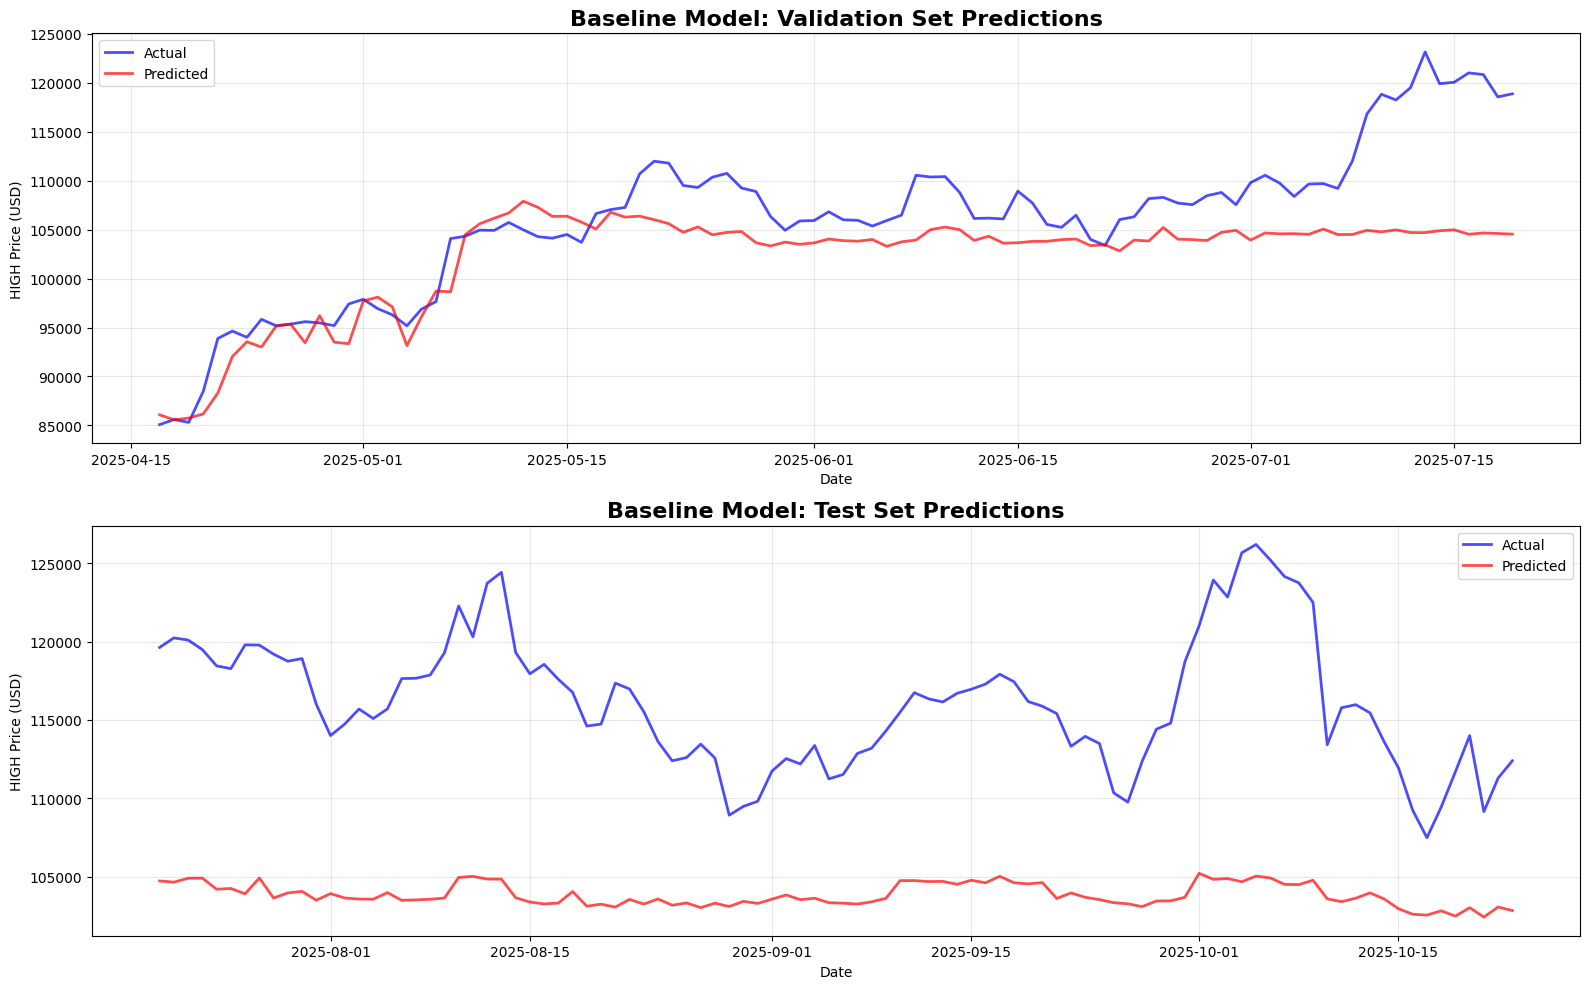


✓ Baseline model captures general trend
  Validation R²: 0.4037
  Test R²: -8.4513


In [10]:
# Plot predictions vs actual
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Validation set
axes[0].plot(timestamps_val, y_val.values, label='Actual', color='blue', linewidth=2, alpha=0.7)
axes[0].plot(timestamps_val, y_val_pred_baseline, label='Predicted', color='red', linewidth=2, alpha=0.7)
axes[0].set_title('Baseline Model: Validation Set Predictions', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('HIGH Price (USD)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].plot(timestamps_test, y_test.values, label='Actual', color='blue', linewidth=2, alpha=0.7)
axes[1].plot(timestamps_test, y_test_pred_baseline, label='Predicted', color='red', linewidth=2, alpha=0.7)
axes[1].set_title('Baseline Model: Test Set Predictions', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('HIGH Price (USD)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Baseline model captures general trend")
print(f"  Validation R²: {baseline_metrics_val['r2']:.4f}")
print(f"  Test R²: {baseline_metrics_test['r2']:.4f}")

## 9. Feature Importance Analysis

Top 20 Most Important Features:
                feature  importance
0                  open      0.6343
3                 close      0.1587
44           min_low_14      0.0440
103    days_since_start      0.0372
2                   low      0.0285
38            min_low_7      0.0262
1                  high      0.0198
10           high_lag_2      0.0057
22           high_lag_7      0.0043
36          ema_close_7      0.0040
59          sma_high_90      0.0025
60         ema_close_90      0.0025
104  price_position_30d      0.0023
47          sma_high_30      0.0018
50           min_low_30      0.0016
58         sma_close_90      0.0013
74           bb_percent      0.0012
39           max_high_7      0.0012
70             bb_upper      0.0010
95         week_of_year      0.0010


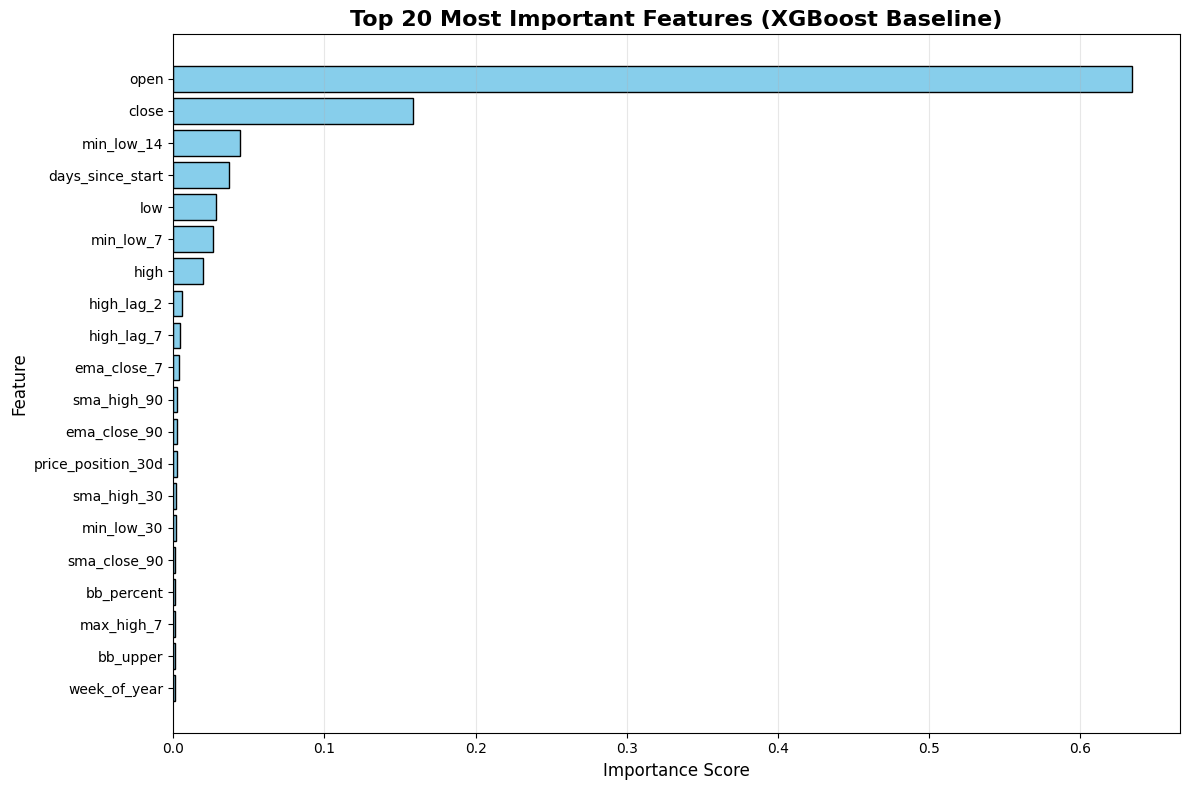

In [11]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': baseline_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print("="*70)
print(feature_importance.head(20))

# Plot top 20
plt.figure(figsize=(12, 8))
top_20 = feature_importance.head(20)
plt.barh(range(len(top_20)), top_20['importance'].values, color='skyblue', edgecolor='black')
plt.yticks(range(len(top_20)), top_20['feature'].values)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Most Important Features (XGBoost Baseline)', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Hyperparameter Tuning with Hyperopt

**Optimize the model using Bayesian optimization**

In [12]:
# Define hyperparameter search space
space = {
    'max_depth': hp.choice('max_depth', range(3, 12)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'n_estimators': hp.choice('n_estimators', range(100, 1000, 50)),
    'min_child_weight': hp.choice('min_child_weight', range(1, 10)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.0001), np.log(1)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1), np.log(10))
}

print("Hyperparameter Search Space:")
print("="*70)
for param, space_def in space.items():
    print(f"  {param}: {space_def}")

Hyperparameter Search Space:
  max_depth: 0 switch
1   hyperopt_param
2     Literal{max_depth}
3     randint
4       Literal{9}
5   Literal{3}
6   Literal{4}
7   Literal{5}
8   Literal{6}
9   Literal{7}
10   Literal{8}
11   Literal{9}
12   Literal{10}
13   Literal{11}
  learning_rate: 0 float
1   hyperopt_param
2     Literal{learning_rate}
3     loguniform
4       Literal{-4.605170185988091}
5       Literal{-1.2039728043259361}
  n_estimators: 0 switch
1   hyperopt_param
2     Literal{n_estimators}
3     randint
4       Literal{18}
5   Literal{100}
6   Literal{150}
7   Literal{200}
8   Literal{250}
9   Literal{300}
10   Literal{350}
11   Literal{400}
12   Literal{450}
13   Literal{500}
14   Literal{550}
15   Literal{600}
16   Literal{650}
17   Literal{700}
18   Literal{750}
19   Literal{800}
20   Literal{850}
21   Literal{900}
22   Literal{950}
  min_child_weight: 0 switch
1   hyperopt_param
2     Literal{min_child_weight}
3     randint
4       Literal{9}
5   Literal{1}
6   Literal{2}


In [13]:
# Define objective function
def objective(params):
    """
    Objective function for Hyperopt to minimize
    """
    # Create model with current hyperparameters
    model = xgb.XGBRegressor(
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        n_estimators=int(params['n_estimators']),
        min_child_weight=int(params['min_child_weight']),
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    # Train model
    model.fit(
        X_train_scaled, y_train,
        eval_set=[(X_val_scaled, y_val)],
        verbose=False
    )
    
    # Evaluate on validation set
    y_val_pred = model.predict(X_val_scaled)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    # Return loss (Hyperopt minimizes this)
    return {'loss': rmse, 'status': STATUS_OK, 'model': model}

print("✓ Objective function defined")

✓ Objective function defined


In [14]:
print("="*70)
print("HYPERPARAMETER OPTIMIZATION")
print("="*70)
print("\nThis may take 10-20 minutes...\n")

# Run Hyperopt
trials = Trials()
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,  # Number of iterations
    trials=trials,
    rstate=np.random.default_rng(RANDOM_STATE)
)

print("\n" + "="*70)
print("OPTIMIZATION COMPLETE!")
print("="*70)
print("\nBest Hyperparameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

HYPERPARAMETER OPTIMIZATION

This may take 10-20 minutes...

100%|██████████| 50/50 [01:07<00:00,  1.36s/trial, best loss: 5147.672794753405]

OPTIMIZATION COMPLETE!

Best Hyperparameters:
  colsample_bytree: 0.6412123066820425
  gamma: 1.721592961884389
  learning_rate: 0.23728891009563025
  max_depth: 2
  min_child_weight: 7
  n_estimators: 10
  reg_alpha: 0.0036293906606096205
  reg_lambda: 4.921248376041161
  subsample: 0.8165188529566973


## 11. Train Final Model with Best Hyperparameters

In [15]:
# Convert best_params to proper format
final_params = {
    'max_depth': int(best_params['max_depth']) + 3,  # +3 because hp.choice starts at 0
    'learning_rate': best_params['learning_rate'],
    'n_estimators': int(best_params['n_estimators']) * 50 + 100,  # Adjust based on choice
    'min_child_weight': int(best_params['min_child_weight']) + 1,
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'gamma': best_params['gamma'],
    'reg_alpha': best_params['reg_alpha'],
    'reg_lambda': best_params['reg_lambda'],
    'random_state': RANDOM_STATE,
    'n_jobs': -1
}

print("Final Model Parameters:")
print("="*70)
for param, value in final_params.items():
    print(f"  {param}: {value}")

Final Model Parameters:
  max_depth: 5
  learning_rate: 0.23728891009563025
  n_estimators: 600
  min_child_weight: 8
  subsample: 0.8165188529566973
  colsample_bytree: 0.6412123066820425
  gamma: 1.721592961884389
  reg_alpha: 0.0036293906606096205
  reg_lambda: 4.921248376041161
  random_state: 42
  n_jobs: -1


In [16]:
print("\nTraining final model...")

# Train final model
final_model = xgb.XGBRegressor(**final_params)

final_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
    verbose=False
)

# Make predictions
y_train_pred_final = final_model.predict(X_train_scaled)
y_val_pred_final = final_model.predict(X_val_scaled)
y_test_pred_final = final_model.predict(X_test_scaled)

print("\n✓ Final model trained!")


Training final model...

✓ Final model trained!


## 12. Final Model Evaluation

In [17]:
print("="*70)
print("FINAL MODEL PERFORMANCE")
print("="*70)

# Evaluate final model
final_metrics_train = evaluate_model(y_train, y_train_pred_final, "Train")
final_metrics_val = evaluate_model(y_val, y_val_pred_final, "Validation")
final_metrics_test = evaluate_model(y_test, y_test_pred_final, "Test")

print("\n" + "="*70)
print("COMPARISON: Baseline vs Optimized")
print("="*70)
print("\nValidation Set:")
print(f"  Baseline  - RMSE: ${baseline_metrics_val['rmse']:,.2f}, R²: {baseline_metrics_val['r2']:.4f}")
print(f"  Optimized - RMSE: ${final_metrics_val['rmse']:,.2f}, R²: {final_metrics_val['r2']:.4f}")
improvement_val = ((baseline_metrics_val['rmse'] - final_metrics_val['rmse']) / baseline_metrics_val['rmse']) * 100
print(f"  Improvement: {improvement_val:.2f}%")

print("\nTest Set:")
print(f"  Baseline  - RMSE: ${baseline_metrics_test['rmse']:,.2f}, R²: {baseline_metrics_test['r2']:.4f}")
print(f"  Optimized - RMSE: ${final_metrics_test['rmse']:,.2f}, R²: {final_metrics_test['r2']:.4f}")
improvement_test = ((baseline_metrics_test['rmse'] - final_metrics_test['rmse']) / baseline_metrics_test['rmse']) * 100
print(f"  Improvement: {improvement_test:.2f}%")

FINAL MODEL PERFORMANCE

Train Metrics:
  RMSE: $0.61
  MAE:  $0.43
  R²:   1.0000
  MAPE: 0.00%

Validation Metrics:
  RMSE: $5,147.67
  MAE:  $3,518.97
  R²:   0.5693
  MAPE: 3.15%

Test Metrics:
  RMSE: $11,367.63
  MAE:  $10,870.59
  R²:   -6.4383
  MAPE: 9.27%

COMPARISON: Baseline vs Optimized

Validation Set:
  Baseline  - RMSE: $6,057.12, R²: 0.4037
  Optimized - RMSE: $5,147.67, R²: 0.5693
  Improvement: 15.01%

Test Set:
  Baseline  - RMSE: $12,813.80, R²: -8.4513
  Optimized - RMSE: $11,367.63, R²: -6.4383
  Improvement: 11.29%


## 13. Visualize Final Model Performance

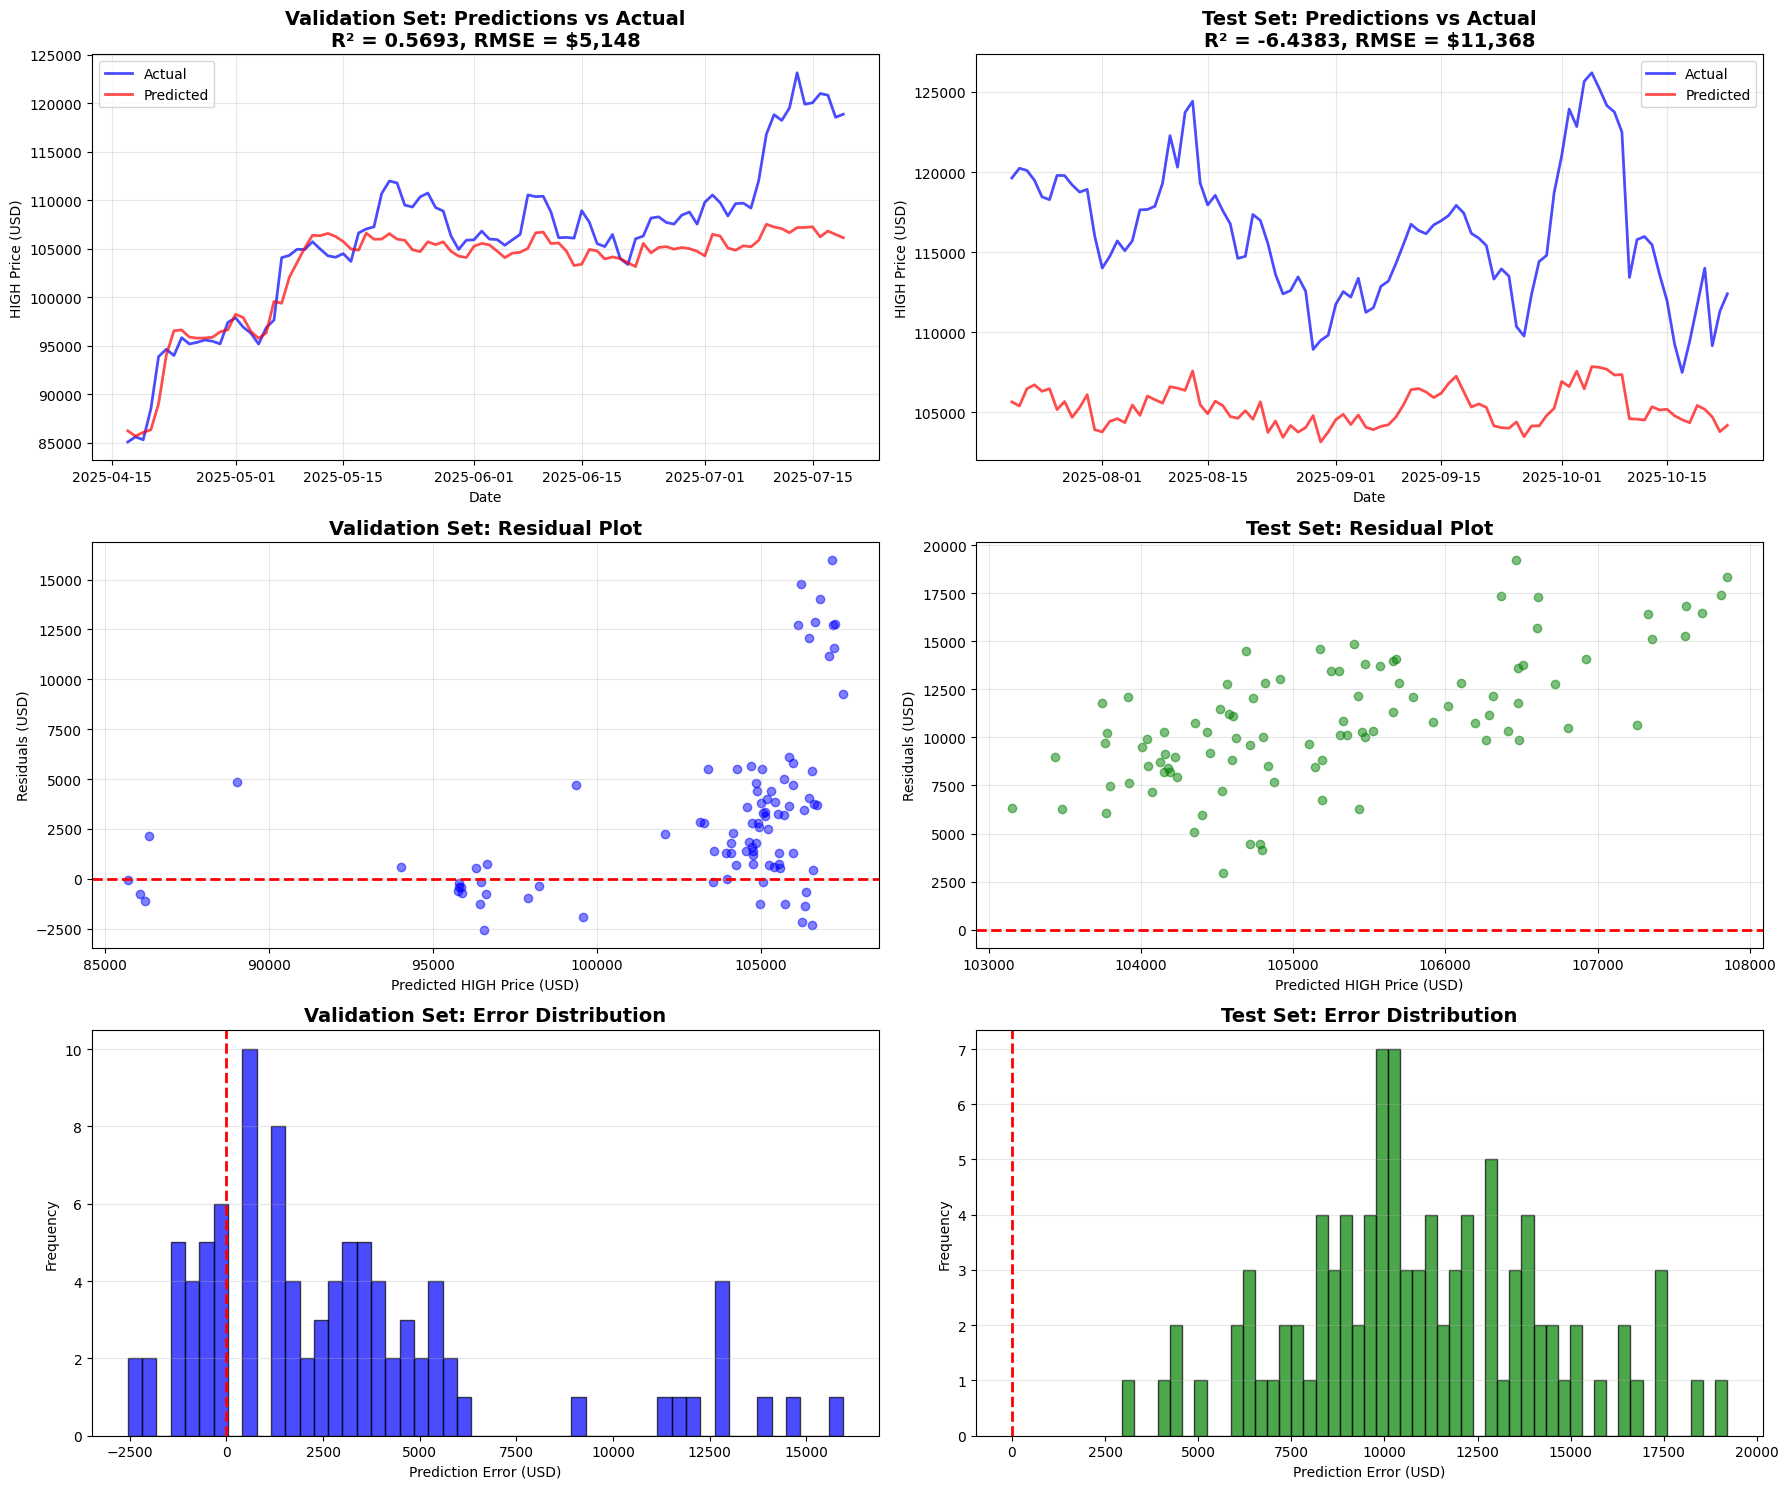


✓ Model performance visualization complete


In [18]:
# Create comprehensive visualization
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

# Row 1: Predictions vs Actual (Validation and Test)
axes[0, 0].plot(timestamps_val, y_val.values, label='Actual', color='blue', linewidth=2, alpha=0.7)
axes[0, 0].plot(timestamps_val, y_val_pred_final, label='Predicted', color='red', linewidth=2, alpha=0.7)
axes[0, 0].set_title(f'Validation Set: Predictions vs Actual\nR² = {final_metrics_val["r2"]:.4f}, RMSE = ${final_metrics_val["rmse"]:,.0f}', 
                     fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('HIGH Price (USD)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(timestamps_test, y_test.values, label='Actual', color='blue', linewidth=2, alpha=0.7)
axes[0, 1].plot(timestamps_test, y_test_pred_final, label='Predicted', color='red', linewidth=2, alpha=0.7)
axes[0, 1].set_title(f'Test Set: Predictions vs Actual\nR² = {final_metrics_test["r2"]:.4f}, RMSE = ${final_metrics_test["rmse"]:,.0f}', 
                     fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('HIGH Price (USD)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Row 2: Residuals
residuals_val = y_val.values - y_val_pred_final
residuals_test = y_test.values - y_test_pred_final

axes[1, 0].scatter(y_val_pred_final, residuals_val, alpha=0.5, color='blue')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('Validation Set: Residual Plot', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Predicted HIGH Price (USD)')
axes[1, 0].set_ylabel('Residuals (USD)')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(y_test_pred_final, residuals_test, alpha=0.5, color='green')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('Test Set: Residual Plot', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Predicted HIGH Price (USD)')
axes[1, 1].set_ylabel('Residuals (USD)')
axes[1, 1].grid(True, alpha=0.3)

# Row 3: Prediction Error Distribution
axes[2, 0].hist(residuals_val, bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[2, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[2, 0].set_title('Validation Set: Error Distribution', fontsize=14, fontweight='bold')
axes[2, 0].set_xlabel('Prediction Error (USD)')
axes[2, 0].set_ylabel('Frequency')
axes[2, 0].grid(True, alpha=0.3, axis='y')

axes[2, 1].hist(residuals_test, bins=50, color='green', alpha=0.7, edgecolor='black')
axes[2, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[2, 1].set_title('Test Set: Error Distribution', fontsize=14, fontweight='bold')
axes[2, 1].set_xlabel('Prediction Error (USD)')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Model performance visualization complete")

## 14. Save the Model and Artifacts

In [19]:
import os

# Create models directory
os.makedirs('../models', exist_ok=True)

# Save the trained model
model_path = '../models/bitcoin_xgboost_model.pkl'
joblib.dump(final_model, model_path)
print(f"✓ Model saved to: {model_path}")

# Save the scaler
scaler_path = '../models/bitcoin_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"✓ Scaler saved to: {scaler_path}")

# Save feature columns
feature_cols_path = '../models/feature_columns.pkl'
joblib.dump(feature_columns, feature_cols_path)
print(f"✓ Feature columns saved to: {feature_cols_path}")

# Save model metadata
metadata = {
    'algorithm': 'XGBoost',
    'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'train_size': len(X_train),
    'val_size': len(X_val),
    'test_size': len(X_test),
    'n_features': len(feature_columns),
    'best_params': final_params,
    'train_metrics': final_metrics_train,
    'val_metrics': final_metrics_val,
    'test_metrics': final_metrics_test,
    'target': 'target_high_next_day'
}

metadata_path = '../models/model_metadata.pkl'
joblib.dump(metadata, metadata_path)
print(f"✓ Metadata saved to: {metadata_path}")

print("\n" + "="*70)
print("✓ ALL ARTIFACTS SAVED SUCCESSFULLY!")
print("="*70)

✓ Model saved to: ../models/bitcoin_xgboost_model.pkl
✓ Scaler saved to: ../models/bitcoin_scaler.pkl
✓ Feature columns saved to: ../models/feature_columns.pkl
✓ Metadata saved to: ../models/model_metadata.pkl

✓ ALL ARTIFACTS SAVED SUCCESSFULLY!


## 15. Test Loading the Model (Verify It Works)

In [20]:
# Load model back
loaded_model = joblib.load(model_path)
loaded_scaler = joblib.load(scaler_path)
loaded_features = joblib.load(feature_cols_path)

# Test prediction on one sample
test_sample = X_test.iloc[0:1]
test_sample_scaled = loaded_scaler.transform(test_sample)
test_prediction = loaded_model.predict(test_sample_scaled)

print("Model Loading Test:")
print("="*70)
print(f"✓ Model loaded successfully")
print(f"✓ Scaler loaded successfully")
print(f"✓ Feature columns loaded successfully ({len(loaded_features)} features)")
print(f"\nTest prediction:")
print(f"  Actual: ${y_test.iloc[0]:,.2f}")
print(f"  Predicted: ${test_prediction[0]:,.2f}")
print(f"  Error: ${abs(y_test.iloc[0] - test_prediction[0]):,.2f}")
print("\n✓ Model is ready for deployment!")

Model Loading Test:
✓ Model loaded successfully
✓ Scaler loaded successfully
✓ Feature columns loaded successfully (116 features)

Test prediction:
  Actual: $119,630.40
  Predicted: $105,654.86
  Error: $13,975.54

✓ Model is ready for deployment!


## 16. Summary and Next Steps

In [21]:
print("="*70)
print("MODEL TRAINING COMPLETE - SUMMARY")
print("="*70)

print("\n📊 Final Model Performance:")
print(f"  Algorithm: XGBoost")
print(f"  Features: {len(feature_columns)}")
print(f"  Training samples: {len(X_train)}")
print(f"\n  Test Set Metrics:")
print(f"    RMSE: ${final_metrics_test['rmse']:,.2f}")
print(f"    MAE:  ${final_metrics_test['mae']:,.2f}")
print(f"    R²:   {final_metrics_test['r2']:.4f}")
print(f"    MAPE: {final_metrics_test['mape']:.2f}%")

print("\n✅ Completed:")
print("  [✓] Data loaded and preprocessed")
print("  [✓] Train/Val/Test split (70/15/15)")
print("  [✓] Baseline model trained")
print("  [✓] Hyperparameter optimization (50 trials)")
print("  [✓] Final model trained with best params")
print("  [✓] Model evaluated on all sets")
print("  [✓] Model and artifacts saved")

print("\n📁 Saved Files:")
print("  ../models/bitcoin_xgboost_model.pkl")
print("  ../models/bitcoin_scaler.pkl")
print("  ../models/feature_columns.pkl")
print("  ../models/model_metadata.pkl")

print("\n🎯 Next Steps:")
print("  1. Create FastAPI to serve the model")
print("  2. Build Docker container for API")
print("  3. Deploy to Render")
print("  4. Create Streamlit visualization component")
print("  5. Integrate with team's Streamlit app")
print("  6. Write final report")

print("\n" + "="*70)
print("✓ MODEL READY FOR DEPLOYMENT!")
print("="*70)

MODEL TRAINING COMPLETE - SUMMARY

📊 Final Model Performance:
  Algorithm: XGBoost
  Features: 116
  Training samples: 441

  Test Set Metrics:
    RMSE: $11,367.63
    MAE:  $10,870.59
    R²:   -6.4383
    MAPE: 9.27%

✅ Completed:
  [✓] Data loaded and preprocessed
  [✓] Train/Val/Test split (70/15/15)
  [✓] Baseline model trained
  [✓] Hyperparameter optimization (50 trials)
  [✓] Final model trained with best params
  [✓] Model evaluated on all sets
  [✓] Model and artifacts saved

📁 Saved Files:
  ../models/bitcoin_xgboost_model.pkl
  ../models/bitcoin_scaler.pkl
  ../models/feature_columns.pkl
  ../models/model_metadata.pkl

🎯 Next Steps:
  1. Create FastAPI to serve the model
  2. Build Docker container for API
  3. Deploy to Render
  4. Create Streamlit visualization component
  5. Integrate with team's Streamlit app
  6. Write final report

✓ MODEL READY FOR DEPLOYMENT!
